# Undercomplete Autoencoder Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing as pp
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

2023-02-03 12:20:51.852430: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-03 12:20:51.852452: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-03 12:20:52.431150: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-03 12:20:52.431222: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-03 12:20:52.431231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [2]:
# fix tensorflow gpu problems
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2023-02-03 12:20:53.342060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 12:20:53.342378: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-03 12:20:53.342457: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-02-03 12:20:53.342528: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-02-03 12:20:53.342587: W tensorflow/c

In [3]:
# check gpu support
gpus = tf.config.list_physical_devices('GPU')
print(len(gpus))
print(tf.test.is_built_with_gpu_support())
print(tf.test.is_built_with_cuda())
print(tf.test.gpu_device_name())

0
True
True



2023-02-03 12:20:53.449209: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 12:20:53.449430: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-02-03 12:20:53.449959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-03 12:20:53.450129: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the 

## Load the data

In [4]:
data = pd.read_csv('./data/mirai/Mirai_dataset.csv', index_col=0, dtype=np.float32)
labels = pd.read_csv('./data/mirai/Mirai_labels.csv', dtype=np.int32)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 764136 entries, 1.0 to 764136.0
Columns: 115 entries, 1.0 to 0.0.54
dtypes: float32(115)
memory usage: 341.0 MB


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764136 entries, 0 to 764135
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       764136 non-null  int32
dtypes: int32(1)
memory usage: 2.9 MB


In [7]:
data.head(5)

,1.0,60.0,0.0,1.0.1,60.0.1,0.0.1,1.0.2,60.0.2,0.0.2,1.0.3,...,0.0.48,0.0.49,0.0.50,1.0.24,60.0.28,0.0.51,60.0.29,0.0.52,0.0.53,0.0.54
0,,,,,,,,,,,,,,,,,,,,,
1.0,1.999983,60.0,0.000000e+00,1.999990,60.0,9.094947e-13,1.999997,60.0,4.547474e-13,2.000000,...,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0
2.0,1.000000,86.0,0.000000e+00,1.000000,86.0,0.000000e+00,1.000000,86.0,0.000000e+00,1.000000,...,0.0,0.0,0.0,1.0,86.0,0.0,86.0,0.0,0.0,0.0
3.0,1.999272,86.0,9.094947e-13,1.999563,86.0,0.000000e+00,1.999854,86.0,9.094947e-13,1.999985,...,0.0,0.0,0.0,1.0,86.0,0.0,86.0,0.0,0.0,0.0
4.0,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,60.0,0.000000e+00,1.000000,...,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0
5.0,1.000000,74.0,0.000000e+00,1.000000,74.0,0.000000e+00,1.000000,74.0,0.000000e+00,1.000000,...,0.0,0.0,0.0,1.0,74.0,0.0,74.0,0.0,0.0,0.0


In [8]:
labels.head(5)

,0
0,0
1,0
2,0
3,0
4,0


In [9]:
data.describe()

,1.0,60.0,0.0,1.0.1,60.0.1,0.0.1,1.0.2,60.0.2,0.0.2,1.0.3,...,0.0.48,0.0.49,0.0.50,1.0.24,60.0.28,0.0.51,60.0.29,0.0.52,0.0.53,0.0.54
count,764136.000000,764136.000000,764136.000000,764136.000000,764136.000000,764136.000000,764136.000000,764136.000000,764136.000000,764136.000000,...,7.641360e+05,764136.000000,764136.000000,764136.000000,764136.000000,764136.000000,764136.000000,7.641360e+05,764136.000000,764136.000000
mean,62.350761,66.255043,70.099174,89.739113,66.271713,94.559898,240.175995,66.290672,143.849915,2317.251953,...,4.556563e+00,-0.000486,-0.000098,20698.412109,66.377167,0.237334,68.730598,5.130032e+00,0.004659,0.000091
std,44.615818,17.588593,1131.776489,59.838459,16.923904,1343.725586,141.576248,15.456532,1625.711792,1352.537231,...,7.694627e+01,0.649533,0.014717,13575.003906,19.792562,2.114585,23.244699,8.699055e+01,0.634564,0.009265
min,1.000000,42.000004,0.000000,1.000000,42.002373,0.000000,1.000000,44.291508,0.000000,1.000000,...,0.000000e+00,-65.889397,-1.057362,1.000000,42.000000,0.000000,42.000000,0.000000e+00,-73.598526,-0.749841
25%,7.951381,60.024849,0.236595,10.293426,60.051337,0.592575,22.328444,60.097115,1.363975,113.456554,...,1.818989e-12,0.000000,0.000000,158.586109,60.000000,0.000002,60.000000,3.637979e-12,0.000000,0.000000
50%,68.425091,60.078346,0.783348,100.562263,60.110451,1.338655,298.392960,60.135586,1.999527,3127.492188,...,6.366463e-12,0.000000,0.000000,30562.675781,60.000000,0.000004,60.000000,1.682565e-11,0.000000,0.000000
75%,103.520470,60.745066,2.929853,142.195202,60.586356,3.576463,344.376740,61.130436,3.531308,3177.945557,...,1.409717e-11,0.000000,0.000000,30737.931641,60.000000,0.000007,72.000000,4.501999e-11,0.000000,0.000000
max,144.071655,624.117432,442869.250000,195.788055,590.000000,400508.593750,425.179962,590.000000,265238.687500,3282.664307,...,1.455177e+04,92.778946,0.800243,30875.636719,1468.000000,130.141937,1468.000000,1.693692e+04,102.044060,0.875271


## Scale the data

In [10]:
# scale the data
scaler = pp.MinMaxScaler()
data = scaler.fit_transform(data)
data = pd.DataFrame(data)
data.describe()

,0,1,2,3,4,5,6,7,8,9,...,105,106,107,108,109,110,111,112,113,114
count,764136.000000,764136.000000,7.641360e+05,764136.000000,764136.000000,764136.000000,764136.000000,764136.000000,764136.000000,764136.000000,...,7.641360e+05,764136.000000,764136.000000,764136.000000,764136.000000,7.641360e+05,764136.000000,7.641360e+05,764136.000000,764136.000000
mean,0.428811,0.041667,1.582842e-04,0.455567,0.044287,0.000236,0.563855,0.040313,0.000542,0.705816,...,3.131279e-04,0.415262,0.569154,0.670369,0.017095,1.823654e-03,0.018745,3.028905e-04,0.419051,0.461465
std,0.311842,0.030215,2.555554e-03,0.307198,0.030883,0.003355,0.333765,0.028324,0.006129,0.412150,...,5.287761e-03,0.004094,0.007923,0.439681,0.013880,1.624830e-02,0.016301,5.136148e-03,0.003613,0.005701
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,0.048587,0.030964,5.342331e-07,0.047710,0.032936,0.000001,0.050282,0.028963,0.000005,0.034268,...,1.250013e-16,0.415265,0.569207,0.005104,0.012623,1.465591e-08,0.012623,2.147957e-16,0.419024,0.461409
50%,0.471268,0.031056,1.768802e-06,0.511131,0.033044,0.000003,0.701101,0.029034,0.000008,0.952715,...,4.375045e-16,0.415265,0.569207,0.989864,0.012623,3.151873e-08,0.012623,9.934302e-16,0.419024,0.461409
75%,0.716567,0.032202,6.615615e-06,0.724866,0.033913,0.000009,0.809507,0.030857,0.000013,0.968090,...,9.687599e-16,0.415265,0.569207,0.995540,0.012623,5.155674e-08,0.021038,2.658097e-15,0.419024,0.461409
max,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000e+00,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000e+00,1.000000,1.000000


## Train-Test Split

In [11]:
# drop the last row
#labels=labels[:-1]
#labels.tail(5)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, shuffle=False, test_size=0.3)

In [13]:
print(f'Number anomalies in train data: {y_train.sum()}')

Number anomalies in train data: 0    413275
dtype: int64


In [14]:
print(f'Number anomalies in test data: {y_test.sum()}')

Number anomalies in test data: 0    229241
dtype: int64


## Define Undercomplete Autoencoder

In [15]:
# model parameters
n_input = X_train.shape[1]
n_hidden = 64

In [16]:
def autoencoder(n_input, n_hidden, lr=0.001):
    # define layers
    inputs = tf.keras.Input(shape=(n_input,))
    dense1 = tf.keras.layers.Dense(n_hidden, activation='relu')
    outputs = tf.keras.layers.Dense(n_input, activation='linear')
    layers = [inputs, dense1, outputs]
    # create model
    model = tf.keras.models.Sequential(layers)
    model.summary()
    # compile model
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    rmse = tf.keras.metrics.RootMeanSquaredError()
    mae = tf.keras.metrics.MeanAbsoluteError()
    model.compile(optimizer=opt, loss='mean_squared_error', metrics=[rmse, mae])
    return model

## Train Autoencoder

In [17]:
model = autoencoder(n_input, n_hidden, lr=0.001)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                7424      
                                                                 
 dense_1 (Dense)             (None, 115)               7475      
                                                                 
Total params: 14,899
Trainable params: 14,899
Non-trainable params: 0
_________________________________________________________________


In [18]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  min_delta=0.0001,
                                                  patience=10,
                                                  verbose=0,
                                                  mode='auto',
                                                  restore_best_weights=True)
history = model.fit(X_train,
                    X_train,
                    epochs=100,
                    batch_size=10000,
                    validation_data=(X_test, X_test),
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/100
54/54 [==============================] - 2s 27ms/step - loss: 0.0374 - root_mean_squared_error: 0.1934 - mean_absolute_error: 0.1202 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0690 - val_mean_absolute_error: 0.0428
Epoch 2/100
54/54 [==============================] - 1s 19ms/step - loss: 0.0034 - root_mean_squared_error: 0.0581 - mean_absolute_error: 0.0328 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0392 - val_mean_absolute_error: 0.0202
Epoch 3/100
54/54 [==============================] - 1s 19ms/step - loss: 0.0015 - root_mean_squared_error: 0.0382 - mean_absolute_error: 0.0194 - val_loss: 7.4621e-04 - val_root_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.0120
Epoch 4/100
54/54 [==============================] - 1s 20ms/step - loss: 8.1217e-04 - root_mean_squared_error: 0.0285 - mean_absolute_error: 0.0133 - val_loss: 4.1754e-04 - val_root_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.0079
Epoch 5/100
54/54 [=========================

Minimal Loss: 0.0000


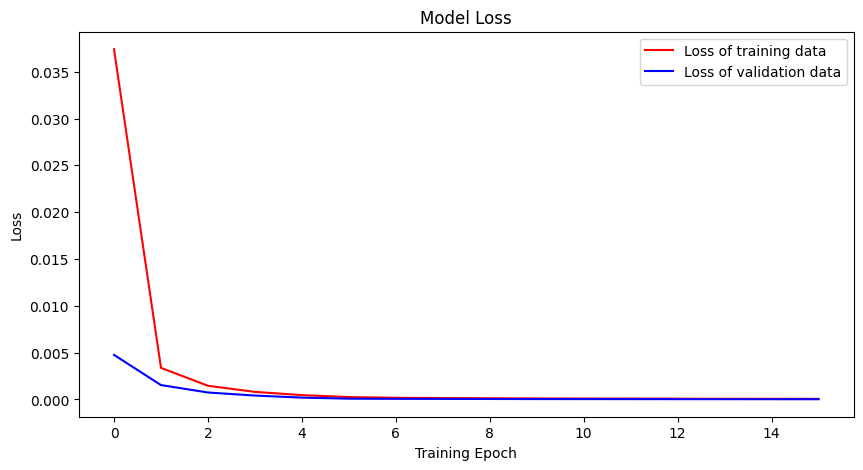

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']
min_loss = min(val_loss)
print(f'Minimal Loss: {min_loss:.4f}')
plt.figure(figsize=(10,5))
plt.plot(loss, 'r', label='Loss of training data')
plt.plot(val_loss, 'b-', label='Loss of validation data')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Training Epoch')
plt.legend()
plt.show()

## Evaluate Autoencoder 

In [20]:
predictions = model.predict(X_test, verbose=1)

7164/7164 [==============================] - 8s 1ms/step


In [21]:
def reconstr_error(original, reconstr):
    errors = np.sqrt(np.sum((original - reconstr)**2, axis=1))
    return errors

In [22]:
errors = reconstr_error(X_test, predictions)

In [23]:
# average precision score train
aps_test = average_precision_score(y_test, errors)
print(f'Average precision score for test: {aps_test:.4f}')

Average precision score for test: 1.0000


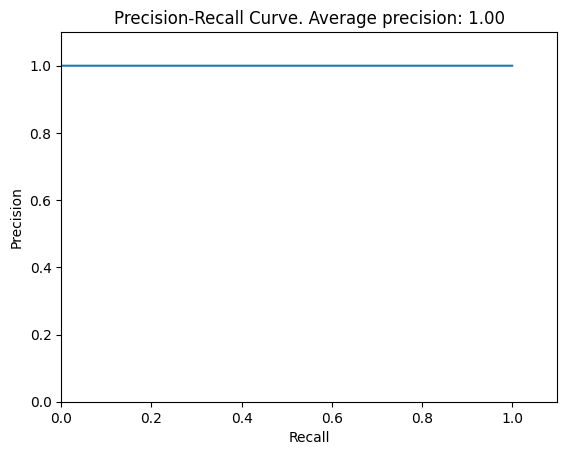

In [24]:
# precision-recall curve for test results
precision, recall, thresholds = precision_recall_curve(y_test, errors)
plt.title(f'Precision-Recall Curve. Average precision: {aps_test:.2f}')
plt.xlabel('Recall')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.ylabel('Precision')
#plt.ylim([0, 1.1])
#plt.xlim([0, 1.0])
plt.plot(recall, precision)
plt.show()

/home/alex/MySci/anomaly/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1009: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


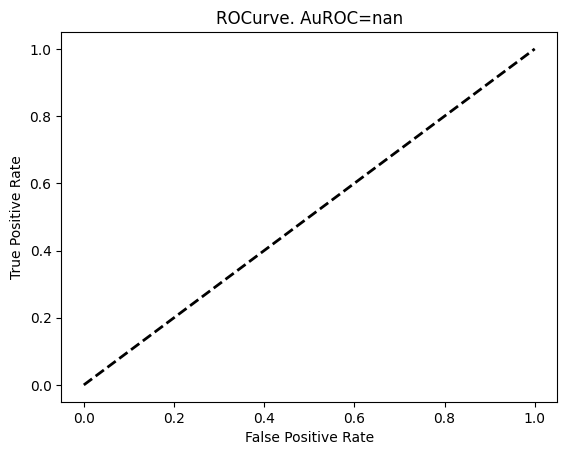

In [25]:
# receiver operational characteristic
fpr, tpr, thresholds = roc_curve(y_test, errors)
auROC = auc(fpr, tpr)
plt.figure()
plt.title(f'ROCurve. AuROC={auROC:.2f}')
plt.plot(fpr, tpr, color='r', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot([0,1], [0,1], color='k', lw=2, linestyle='--')
plt.show()